# Chapter 4: Image Classification with Medical X-rays
This notebook demonstrates a simple machine learning pipeline using publicly available chest X-ray images. We create a small dataset from the [COVID-19 chest x-ray dataset](https://github.com/ieee8023/covid-chestxray-dataset) and build a classifier to distinguish COVID-19 from other findings.

## Download sample data
We fetch a handful of radiographs and organize them into `data/covid` and `data/noncovid` folders.

In [2]:
import os, requests
if not os.path.exists('metadata.csv'):
    url = 'https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/metadata.csv'
    r = requests.get(url)
    open('metadata.csv','wb').write(r.content)
print('metadata.csv ready')

metadata.csv ready


In [3]:
import os, pandas as pd, requests
from pathlib import Path

url_prefix = 'https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/'

df = pd.read_csv('metadata.csv')

covid = df[df['finding']=='Pneumonia/Viral/COVID-19'].head(25)
noncovid = df[df['finding']!='Pneumonia/Viral/COVID-19'].head(25)
Path('data/covid').mkdir(parents=True, exist_ok=True)
Path('data/noncovid').mkdir(parents=True, exist_ok=True)

for _, row in covid.iterrows():
    url = url_prefix + row['folder'] + '/' + row['filename']
    p = Path('data/covid')/row['filename']
    if not p.exists():
        r = requests.get(url)
        if r.status_code==200:
            p.write_bytes(r.content)

for _, row in noncovid.iterrows():
    url = url_prefix + row['folder'] + '/' + row['filename']
    p = Path('data/noncovid')/row['filename']
    if not p.exists():
        r = requests.get(url)
        if r.status_code==200:
            p.write_bytes(r.content)
print('Images downloaded:', len(os.listdir('data/covid')), len(os.listdir('data/noncovid')))

Images downloaded: 25 25


## Prepare dataset
We load each image, convert to grayscale and resize to 64x64 pixels so that simple algorithms like Support Vector Machines can handle them.

In [4]:
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report

X = []
y = []
for label, folder in enumerate(['covid', 'noncovid']):
    for fname in os.listdir('data/'+folder):
        img = Image.open('data/'+folder+'/'+fname).convert('L').resize((64,64))
        X.append(np.array(img).ravel())
        y.append(label)
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
print('Train size:', len(X_train), 'Test size:', len(X_test))

Train size: 35 Test size: 15


## Evaluate model

In [5]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred, target_names=['COVID','NonCOVID']))

              precision    recall  f1-score   support

       COVID       0.78      0.88      0.82         8
    NonCOVID       0.83      0.71      0.77         7

    accuracy                           0.80        15
   macro avg       0.81      0.79      0.80        15
weighted avg       0.80      0.80      0.80        15



## Summary
This simple pipeline illustrates the fundamentals of medical image classification:
- Acquire and organize labeled images
- Convert images to a standard size
- Train a conventional machine learning model
While real-world tasks require much larger datasets and more sophisticated models, the same core steps apply.

Confusion Matrix:


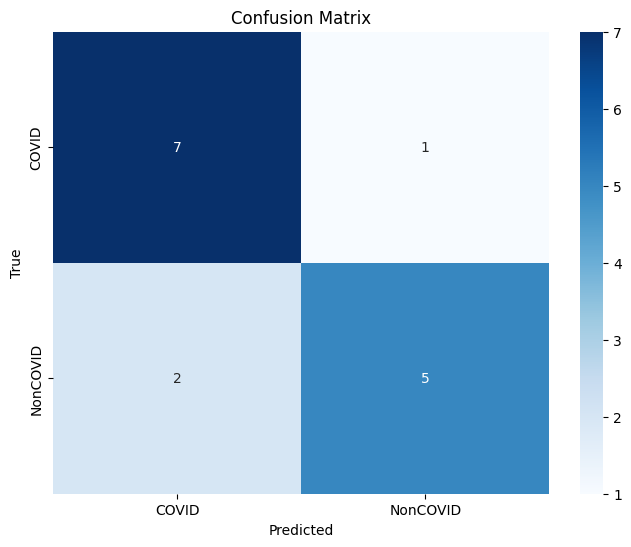


Sample Images with Predictions:


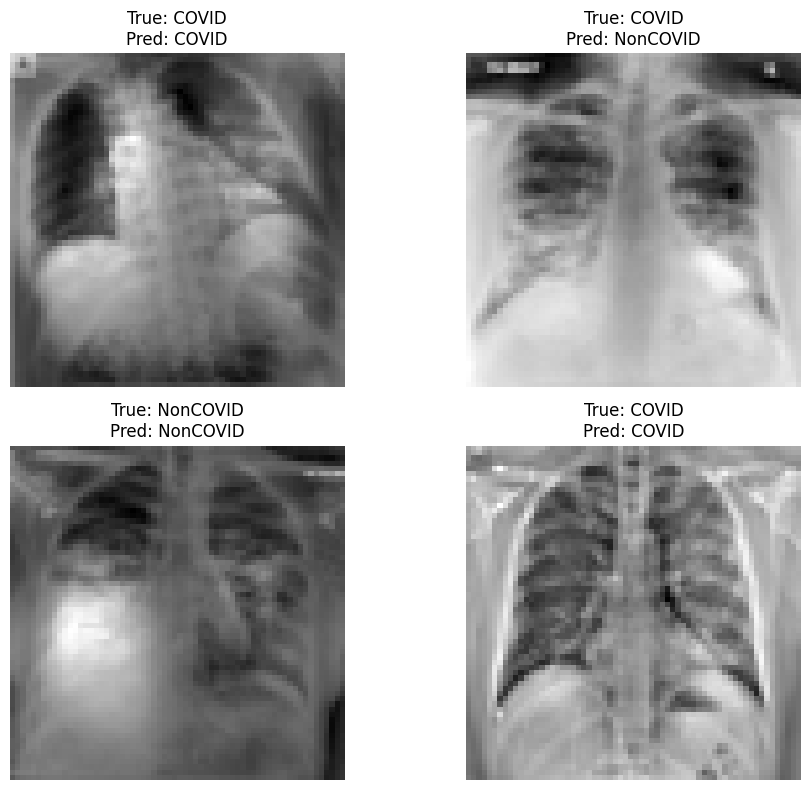


ROC Curve:


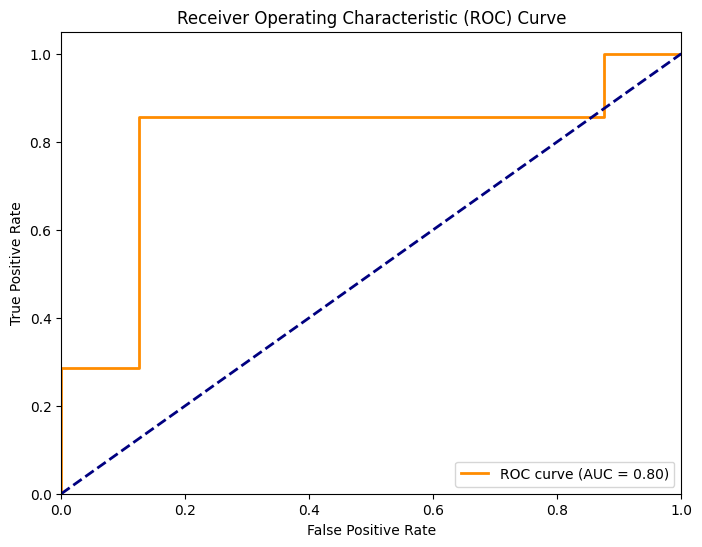


Detailed Metrics Table:


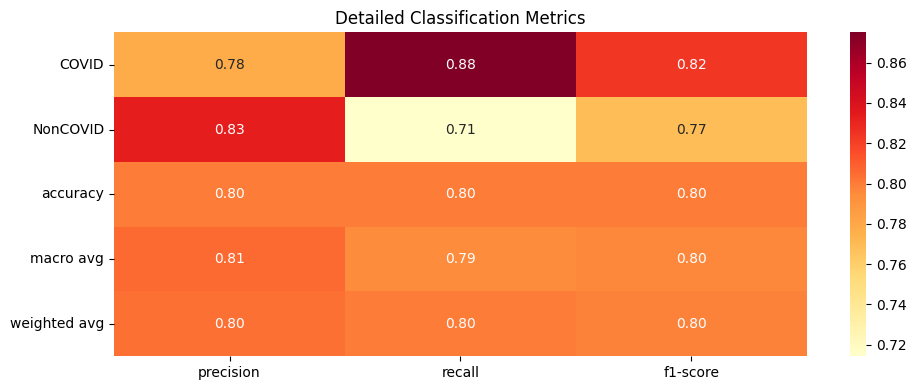

In [6]:
# Import visualization functions
from visualizations import plot_confusion_matrix, plot_sample_images, plot_roc_curve, plot_metrics_table

# Generate all visualizations
print("Confusion Matrix:")
plot_confusion_matrix(y_test, pred)

print("\nSample Images with Predictions:")
plot_sample_images(X_test, y_test, pred)

print("\nROC Curve:")
y_score = clf.decision_function(X_test)
plot_roc_curve(y_test, y_score)

print("\nDetailed Metrics Table:")
plot_metrics_table(y_test, pred)